<a href="https://colab.research.google.com/github/Joboreh97/Codes-that-function/blob/main/tutorials/phy/test_validation_2_epochs_0.8coderate_0.07phasenoise_3000batches_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

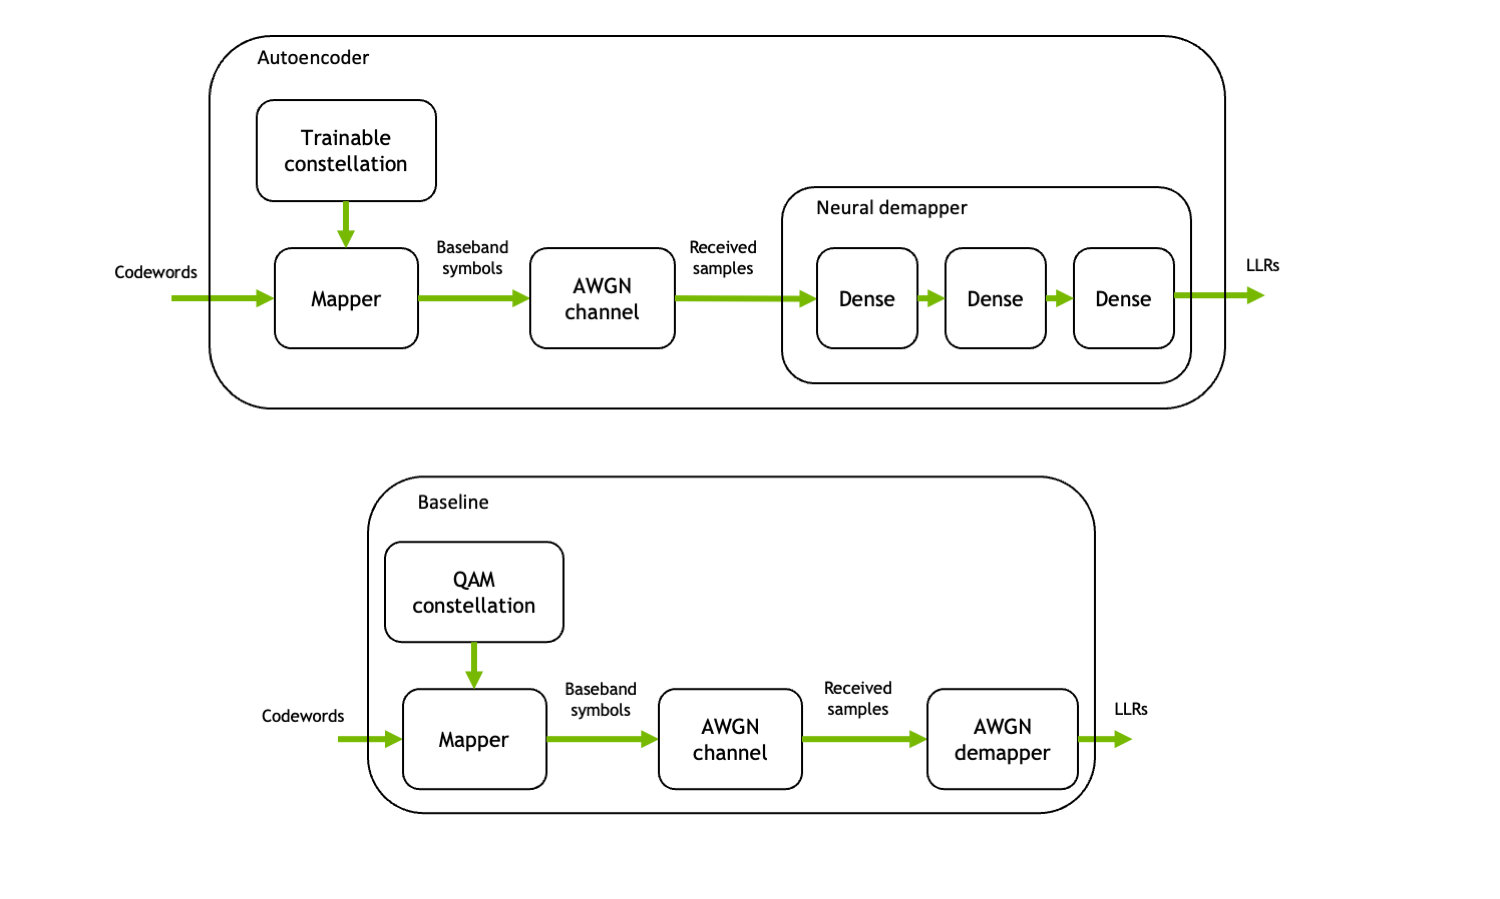


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [1]:
!pip show tensorflow
!pip show tf_keras

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, sionna, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: tf_keras
Version: 2.18.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: tensorflow
Required-by: dopamine_rl, tensorflow-hub, tensorflow_decision_forests


In [2]:
# ✅ Set this before importing TensorFlow to use legacy tf.keras (Keras 2)
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Optional: Set GPU and logging behavior
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Add this to disable XNNPACK delegate for TFLite interpreter:
os.environ["TFLITE_ENABLE_XNNPACK"] = "0"
os.environ["TFLITE_DISABLE_SELECT_TF_OPS"] = "1"     # Add this
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"            # Add this too
# ✅ Now import TensorFlow and confirm it's using legacy Keras
import tensorflow as tf
import tf_keras
print("Legacy tf_keras version:", tf_keras.__version__)  # Should print 2.18.0

# ✅ Sionna setup
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
        print("Installing Sionna and restarting the runtime. Please run the cell again.")
        os.system("pip install sionna")
        os.kill(os.getpid(), 5)
    else:
        raise e

# ✅ GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# ✅ Suppress warnings from TF logger
tf.get_logger().setLevel('ERROR')

# ✅ Imports from tf.keras instead of standalone keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

# ✅ Sionna imports
from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

# ✅ Seed
sionna.phy.config.seed = 42

# ✅ Jupyter/plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle


Legacy tf_keras version: 2.18.0


In [3]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.6 MB/s eta 0:00:00


# Simulation Parameter

In [4]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 40

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.8 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 3000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700
num_training_iterations_rl_finetuning = 300
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_conventional_training_pruned = "awgn_autoencoder_weights_conventional_training_pruned" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_qat = "awgn_autoencoder_weights_qat" # Filename to save the autoencoder weights once QAT is done
model_weights_path_quantized_conventional_training = "awgn_autoencoder_quantized_weights_conventional_training"
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

# Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

**Neural Demapper for AWGN Channel**

In [5]:
def preprocess_complex_input(y, no, num_symbols_per_codeword):
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    no_db = log10_fn(no)  # shape: [batch_size, 1]
    re = tf.math.real(y)  # shape: [batch_size, num_symbols_per_codeword]
    im = tf.math.imag(y)

    # Broadcast no_db to match shape of re: [batch_size, num_symbols_per_codeword]
    no_db = tf.broadcast_to(no_db, tf.shape(re))

    # Stack into shape: [batch_size, num_symbols_per_codeword, 3]
    z = tf.stack([re, im, no_db], axis=-1)
    return z

In [6]:
from tensorflow.keras.layers import Input, Dense

def create_functional_demapper_real_input(num_symbols_per_codeword, num_bits_per_symbol):
    z_input = Input(shape=(num_symbols_per_codeword, 3), dtype=tf.float32, name="z_input")
    x = Dense(128, activation="relu")(z_input)
    x = Dense(128, activation="relu")(x)
    llr = Dense(num_bits_per_symbol)(x)
    return Model(inputs=z_input, outputs=llr, name="FunctionalDemapperReal")



In [7]:
import tensorflow_model_optimization as tfmot

# Float32 demapper
float_demapper = create_functional_demapper_real_input(
    num_symbols_per_codeword, num_bits_per_symbol)

# QAT wrapper
qat_demapper_model = tfmot.quantization.keras.quantize_model(float_demapper)



**Neural Demapper for (Phase Noise + AWGN) Channel**

In [8]:
import tensorflow as tf
from sionna.phy.utils import log10

def preprocess_complex_phase_noise_input(y, no, sigma_phi, num_symbols_per_codeword):
    """
    Preprocess inputs for the phase noise demapper *without* internal preprocessing.
    """
    def log10_fn(x):
        return tf.math.log(x) / tf.math.log(tf.constant(10, dtype=tf.float32))

    batch_size = tf.shape(y)[0]
    no = tf.convert_to_tensor(no, dtype=tf.float32)
    sigma_phi = tf.convert_to_tensor(sigma_phi, dtype=tf.float32)
    no = tf.reshape(no, [-1, 1]) if len(no.shape) < 2 else no
    sigma_phi = tf.reshape(sigma_phi, [-1, 1]) if len(sigma_phi.shape) < 2 else sigma_phi
    no_db = log10_fn(no)
    no_db_tiled = tf.tile(no_db, [1, num_symbols_per_codeword])
    sigma_phi_tiled = tf.tile(sigma_phi, [1, num_symbols_per_codeword])
    z = tf.stack([
        tf.math.real(y),
        tf.math.imag(y),
        no_db_tiled,
        sigma_phi_tiled
    ], axis=2)
    return z

512 Neurones Demapper

In [9]:
def create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(512, activation='relu', name='dense1')(z_input)
    x = Dense(512, activation='relu', name='dense2')(x)
    x = Dense(512, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise")
    return model


In [10]:
float_demapper_phase_noise = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)

64 Neurones Demapper

In [11]:
def create_256_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(256, activation='relu', name='dense1')(z_input)
    x = Dense(256, activation='relu', name='dense2')(x)
    x = Dense(256, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise")
    return model

In [12]:
def create_64_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(64, activation='relu', name='dense1')(z_input)
    x = Dense(64, activation='relu', name='dense2')(x)
    x = Dense(64, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise64")
    return model

32 Neurones Demapper

In [13]:
def create_32_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(32, activation='relu', name='dense1')(z_input)
    x = Dense(32, activation='relu', name='dense2')(x)
    x = Dense(32, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise32")
    return model


In [14]:
def create_16_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True):
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = Dense(16, activation='relu', name='dense1')(z_input)
    x = Dense(16, activation='relu', name='dense2')(x)
    x = Dense(16, activation='relu', name='dense3')(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = Dense(output_units, activation=None, name='dense_out')(x)
    model = Model(inputs=z_input, outputs=llr, name="FunctionalDemapperPhaseNoise32")
    return model

**Demapper Prunning**

In [15]:
pruning_params = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 0,
    "end_step": 1000,
}

In [16]:
def create_pruned_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, pruning_params, bitwise=True):
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=pruning_params["initial_sparsity"],
        final_sparsity=pruning_params["final_sparsity"],
        begin_step=pruning_params["begin_step"],
        end_step=pruning_params["end_step"],
    )
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    z_input = Input(shape=(250, 4), dtype=tf.float32, name="z_input")
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense1'), pruning_schedule=pruning_schedule)(z_input)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense2'), pruning_schedule=pruning_schedule)(x)
    x = prune_low_magnitude(Dense(512, activation='relu', name='pruned_dense3'), pruning_schedule=pruning_schedule)(x)
    output_units = num_bits_per_symbol if bitwise else 2**num_bits_per_symbol
    llr = prune_low_magnitude(Dense(output_units, activation=None, name='pruned_dense_out'), pruning_schedule=pruning_schedule)(x)
    model = Model(inputs=z_input, outputs=llr, name="PrunedFunctionalDemapperPhaseNoise")
    return model

**Phase Noise**

In [17]:
class PhaseNoise(Block):
    def __init__(self, *, precision=None, **kwargs):
        super().__init__(precision=precision, **kwargs)

    def call(self, x, sigma):
        phi = tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=1.0,
            dtype=self.rdtype
        )
        sigma = expand_to_rank(sigma, tf.rank(x), axis=-1)
        sigma = tf.cast(sigma, self.rdtype)
        phi *= sigma
        phase_rotation = tf.complex(tf.math.cos(phi), tf.math.sin(phi))
        return x * phase_rotation


**Phase Noise Gaussian**

In [18]:
class PhaseNoiseGaussian(tf.keras.layers.Layer):
    def __init__(self, dtype=tf.complex64, name="phase_noise_gaussian", **kwargs):
        super().__init__(dtype=dtype, name=name, **kwargs)
        self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype
        self.start_phase_init = -1*np.pi
        self.start_phase_width = np.pi

    def call(self, inputs):
        print('*********Inside Gaussian Distributed PN************')
        x, sigma_phi = inputs
        var = 1.0
        var_dim = tf.cast(var, x.dtype.real_dtype)/tf.cast(2, x.dtype.real_dtype)
        stddev = tf.sqrt(var_dim)
        noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype.real_dtype)
        sigma_phi = expand_to_rank(sigma_phi, tf.rank(x), axis=-1)
        sigma_phi = tf.cast(sigma_phi, self._real_dtype)
        noise *= tf.cast(sigma_phi, noise.dtype)
        pnr = tf.math.cos(noise)
        pni = tf.math.sin(noise)
        pn = tf.complex(pnr,pni)
        return x*pn

## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [19]:
import tensorflow as tf

class DynamicBinarySource(tf.keras.layers.Layer):
    """Custom binary source layer supporting dynamic batch sizes"""
    def __init__(self, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)

    def call(self, shape):
        # shape: Tensor containing [batch_size, num_bits]
        u = tf.random.uniform(shape, minval=0, maxval=1, dtype=self.dtype)
        return tf.where(u < 0.5, 0.0, 1.0)

In [20]:
import tensorflow as tf
import math
import tensorflow_model_optimization as tfmot

sigmaphi = 0.07
stddev_sigmaphi = math.sqrt(sigmaphi)

class E2ESystemConventionalTraining(tf.keras.Model):
    def __init__(self, training, use_pruning=False, pruning_params=None, pretrained_weights_path=None, demapper_type='512', name="e2e_system"):
        super().__init__(name=name)
        self._training = training



        self._use_pruning = use_pruning
        self._demapper_type = demapper_type

        self._binary_source = DynamicBinarySource(dtype=tf.float32)
        self._num_bits_per_symbol = num_bits_per_symbol
        self._code_rate = k / n

        if not self._training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        qam_points = Constellation("qam", num_bits_per_symbol).points
        initial_points_r = tf.math.real(qam_points)
        initial_points_i = tf.math.imag(qam_points)

        self.points_r = self.add_weight(name='points_r', shape=initial_points_r.shape, initializer="zeros")
        self.points_i = self.add_weight(name='points_i', shape=initial_points_i.shape, initializer="zeros")
        self.points_r.assign(initial_points_r)
        self.points_i.assign(initial_points_i)

        points = tf.complex(self.points_r, self.points_i)
        self.constellation = Constellation("custom", num_bits_per_symbol, points=points, normalize=True, center=True)
        self._mapper = Mapper(constellation=self.constellation)

        self._phase_noise = PhaseNoiseGaussian(name="phase_noise")
        self._channel = AWGN()

        if self._use_pruning and pruning_params is not None:
            units = 512
            if demapper_type == '512':
                units = 512
            elif demapper_type == '256':
                units = 256
            elif demapper_type == '64':
                units = 64
            elif demapper_type == '32':
                units = 32
            elif demapper_type == '16':
                units = 16
            else:
                raise ValueError(f"Unsupported demapper_type: {demapper_type} for pruning.")
            self._demapper = create_pruned_functional_demapper_phase_noise_from_preprocessed(
                num_bits_per_symbol, pruning_params, bitwise=True)
        else:
            if demapper_type == '512':
                self._demapper = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '256':
                self._demapper = create_256_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '64':
                self._demapper = create_64_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '32':
                self._demapper = create_32_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            elif demapper_type == '16':
                self._demapper = create_16_unit_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol, bitwise=True)
            else:
                raise ValueError(f"Unsupported demapper_type: {demapper_type}. Use '512', '64', '32', or '16'.")

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, inputs, training=False):
        if self._training:
            c = inputs[0]
            ebno_db = inputs[1]
        else:
            if not (isinstance(inputs, (tuple, list)) and len(inputs) == 2):
                raise ValueError("Input must be a tuple (x, ebno_db).")
            x, ebno_db = inputs
            batch_size = tf.shape(x)[0]

        if not self._training:
            shape = tf.stack([batch_size, k])
            b = self._binary_source(shape)
            c = self._encoder(b)

        x_mapped = self._mapper(c)
        batch_size = tf.shape(x_mapped)[0]  # Safe to use now

        sigma_phi_tensor = tf.fill([batch_size, 1], stddev_sigmaphi)
        x_phase_noisy = self._phase_noise((x_mapped, sigma_phi_tensor))
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._code_rate)

        y = self._channel(x_phase_noisy, no)

        z = preprocess_complex_phase_noise_input(y, no, sigma_phi_tensor, num_symbols_per_codeword)
        llr = self._demapper(z)

        if self._training:
            c_reshaped = tf.reshape(c, [batch_size, num_symbols_per_codeword, num_bits_per_symbol])
            loss = self._bce(c_reshaped, llr)
            return loss
        else:
            llr_reshaped = tf.reshape(llr, [batch_size, n])
            b_hat = self._decoder(llr_reshaped)
            return b, b_hat

    def train_step(self, data):
          (inputs, _labels) = data  # Unpack ((x, ebno_db), None)
          with tf.GradientTape() as tape:
              loss = self(inputs, training=True)  # Now inputs = (x, ebno_db)
          gradients = tape.gradient(loss, self.trainable_variables)
          self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
          return {"loss": loss}





A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [21]:
def print_pruned_layer_sparsity(layer):
    for weight in layer.weights:
        w = weight.numpy()
        sparsity = np.mean(w == 0)
        print(f"{layer.name} ({weight.name}): sparsity = {sparsity:.3f}")

def print_model_sparsity(model):
    for layer in model.layers:
        print_pruned_layer_sparsity(layer)

**Training Pipeline**

In [22]:
target_sparsity = 0.875
pruning_params_transfer = {
    'initial_sparsity': 0.0, # Start pruning from 50% sparsity
    'final_sparsity': target_sparsity,
    'begin_step': 0, # Start immediately
    'end_step': num_training_iterations_conventional # Or some other number of steps
}

In [23]:
pruning_params_normal = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 2001,
    "end_step": 3000,
}

In [24]:
# def gen():
#     for _ in range(num_training_iterations_conventional):
#         ebno_db = tf.random.uniform(
#             shape=[training_batch_size],
#             minval=ebno_db_min,
#             maxval=ebno_db_max
#         )
#         x = tf.zeros([training_batch_size, 1])
#         yield x, ebno_db

# data_gen = tf.data.Dataset.from_generator(
#     gen,
#     output_signature=(
#         tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
#         tf.TensorSpec(shape=(None,), dtype=tf.float32)
#     )
# )

# # Optional: Prefetch for better performance
# data_gen = data_gen.prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
# # Re-use or create a new generator instance for validation
# # If gen() provides unique random samples each time, this is fine.
# # Otherwise, you might want a fixed validation set for consistency.
# data_val_gen = tf.data.Dataset.from_generator(
#     gen,
#     output_signature=(
#         tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
#         tf.TensorSpec(shape=(None,), dtype=tf.float32)
#     )
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
def gen():
    for _ in range(num_training_iterations_conventional):
        ebno_db = tf.random.uniform(
            shape=(training_batch_size,),  # shape = (batch_size,)
            minval=ebno_db_min,
            maxval=ebno_db_max,
            dtype=tf.float32
        )
        c = tf.random.uniform(
            shape=(training_batch_size, n),
            minval=0,
            maxval=2,
            dtype=tf.int32
        )
        c = tf.cast(c, tf.float32)
        yield (c, ebno_db), c  # inputs=(c, ebno_db), labels=c


data_gen = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        (
            tf.TensorSpec(shape=(training_batch_size, n), dtype=tf.float32),     # c
            tf.TensorSpec(shape=(training_batch_size,), dtype=tf.float32)        # ebno_db
        ),
        tf.TensorSpec(shape=(training_batch_size, n), dtype=tf.float32)          # label c
    )
).prefetch(tf.data.AUTOTUNE)



In [27]:
import numpy as np

num_val_batches = 100  # set according to your validation_steps
val_c = np.random.randint(0, 2, (num_val_batches * training_batch_size, n)).astype(np.float32)
val_ebno = np.random.uniform(ebno_db_min, ebno_db_max, (num_val_batches * training_batch_size)).astype(np.float32)


def val_gen():
    for i in range(num_val_batches):
        sl0 = i * training_batch_size
        sl1 = (i + 1) * training_batch_size
        yield (val_c[sl0:sl1], val_ebno[sl0:sl1]), val_c[sl0:sl1]
data_val_gen = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
        (
            tf.TensorSpec((training_batch_size, n), tf.float32),
            tf.TensorSpec((training_batch_size,), tf.float32)
        ),
        tf.TensorSpec((training_batch_size, n), tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)



In [28]:
# 1. Train the 512-unit dense model
print("Training conventional model (512-unit demapper)...")
model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='512')
model_conventional.compile(optimizer=tf.keras.optimizers.Adam())

history_512_unit = model_conventional.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_conventional.save_weights('conventional_weights_512.h5')

# 2. Train the 64-unit dense model
print("Training 64-unit model...")
model_64unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='64')
model_64unit.compile(optimizer=tf.keras.optimizers.Adam())

history_64_unit = model_64unit.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_64unit.save_weights('model_weights_64unit.h5')

# 3. Train the 32-unit dense model
print("Training 32-unit model...")
model_32unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='32')
model_32unit.compile(optimizer=tf.keras.optimizers.Adam())

history_32_unit = model_32unit.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_32unit.save_weights('model_weights_32unit.h5')

# 4. Train the 16-unit dense model
print("Training 16-unit model...")
model_16unit = E2ESystemConventionalTraining(training=True, use_pruning=False, demapper_type='16')
model_16unit.compile(optimizer=tf.keras.optimizers.Adam())

history_16_unit = model_16unit.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100
)
model_16unit.save_weights('model_weights_16unit.h5')

# 5. Fine-tune pruned model (starting from pretrained 512-unit)
print("Pruning and fine-tuning the pretrained 512-unit model...")
model_pruned_from_pretrained = E2ESystemConventionalTraining(
    training=True,
    use_pruning=True,
    pruning_params=pruning_params,
    demapper_type='512'
)
model_pruned_from_pretrained.compile(optimizer=tf.keras.optimizers.Adam())

# Build the model (required for weight loading)
dummy_input = (tf.zeros([1, n]), tf.zeros([1]))

model_pruned_from_pretrained(dummy_input, training=False)

# Load pretrained dense weights
model_pruned_from_pretrained.load_weights('conventional_weights_512.h5', by_name=True, skip_mismatch=True)

pruning_callbacks_transfer = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs_transfer')
]

history_pruned_from_pretrained = model_pruned_from_pretrained.fit(
    data_gen,
    epochs=2,
    verbose=2,
    validation_data=data_val_gen,
    validation_steps=100,
    callbacks=pruning_callbacks_transfer
)

print("\nPruned demapper sparsity BEFORE stripping:")
print_model_sparsity(model_pruned_from_pretrained._demapper)

# Strip pruning wrappers for final saved model
model_pruned_from_pretrained._demapper = tfmot.sparsity.keras.strip_pruning(model_pruned_from_pretrained._demapper)

print("\nPruned demapper sparsity AFTER stripping:")
print_model_sparsity(model_pruned_from_pretrained._demapper)

model_pruned_from_pretrained.save_weights('model_weights_pruned_from_pretrained_512_to_64_equivalent.h5')

Training conventional model (512-unit demapper)...
Epoch 1/2
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
3000/3000 - 6718s - loss: 0.0431 - val_loss: 0.0000e+00 - 6718s/epoch - 2s/step
Epoch 2/2
3000/3000 - 6739s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 6739s/epoch - 2s/step
Training 64-unit model...
Epoch 1/2
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
3000/3000 - 272s - loss: 0.0431 - val_loss: 0.0000e+00 - 272s/epoch - 91ms/step
Epoch 2/2
3000/3000 - 265s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 265s/epoch - 88ms/step
Training 32-unit model...
Epoch 1/2
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
3000/3000 - 124s - loss: 0.0623 - val_loss: 0.0000e

In [29]:


# # 1. Build and train the conventional model
# print("Training conventional model (512-unit demapper)...")
# model_conventional = E2ESystemConventionalTraining(training=True, use_pruning=False,demapper_type='512')
# model_conventional.compile(optimizer=tf.keras.optimizers.Adam())

# history_512_unit = model_conventional.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen, # <--- Add this line
#     validation_steps=100 # <--- Important: Define how many validation batches to run per epoch
#                           # This should be a reasonable number to get a good estimate
# )

# model_conventional.save_weights('conventional_weights_512.h5')

# # 2. Build and train the 64-unit model
# # Use a new data generator for the 64-unit model


# print("Training 64-unit model...")
# model_64unit = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=False,
#     demapper_type='64'
# )
# model_64unit.compile(optimizer=tf.keras.optimizers.Adam())
# history_64_unit = model_64unit.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen, # <--- Add this line
#     validation_steps=100 # <--- Important: Define how many validation batches to run per epoch
#                           # This should be a reasonable number to get a good estimate
# )
# model_64unit.save_weights('model_weights_64unit.h5')


# # 3. Build and train the 32-unit model
# print("Training 32-unit model...")
# model_32unit = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=False,
#     demapper_type='32'
# )
# model_32unit.compile(optimizer=tf.keras.optimizers.Adam())


# history_32_unit = model_32unit.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen, # <--- Add this line
#     validation_steps=100 # <--- Important: Define how many validation batches to run per epoch
#                           # This should be a reasonable number to get a good estimate
# )
# model_32unit.save_weights('model_weights_32unit.h5')



# # 4. Build and train the 16-unit model
# print("Training 16-unit model...")
# model_16unit = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=False,
#     demapper_type='16'
# )
# model_16unit.compile(optimizer=tf.keras.optimizers.Adam())


# history_16_unit = model_16unit.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen, # <--- Add this line
#     validation_steps=100 # <--- Important: Define how many validation batches to run per epoch
#                           # This should be a reasonable number to get a good estimate
# )
# model_16unit.save_weights('model_weights_16unit.h5')




# # 5. Build and train the pruned model (using 512-unit as base)




# #6 Pretrained 512- Unit Model Pruning


# model_pruned_from_pretrained = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=True, # Enable pruning
#     pruning_params=pruning_params,
#     demapper_type='512' # Keep base as 512-unit for pruning
# )

# # Compile the model
# model_pruned_from_pretrained.compile(optimizer=tf.keras.optimizers.Adam())

# # IMPORTANT: Load the weights from the fully trained 512-unit model
# # You need to build the model first to load weights
# dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
# model_pruned_from_pretrained(dummy_input, training=False) # Build the graph
# model_pruned_from_pretrained.load_weights('conventional_weights_512.h5', by_name=True, skip_mismatch=True)


# # Pruning callbacks for this new training phase
# pruning_callbacks_transfer = [
#     tfmot.sparsity.keras.UpdatePruningStep(),
#     tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs_transfer')
# ]


# print(f"\nPruning and fine-tuning from pre-trained 512-unit model to {target_sparsity*100:.2f}% sparsity...")
# history_pruned_from_pretrained = model_pruned_from_pretrained.fit(
#     data_gen,
#     epochs=2,
#     verbose=2,
#     validation_data=data_val_gen, # <--- Add this line
#     validation_steps=100 # <--- Important: Define how many validation batches to run per epoch
#                           # This should be a reasonable number to get a good estimate
# )
# # Print sparsity before stripping
# print("\nPruned demapper sparsity BEFORE stripping:")
# print_model_sparsity(model_pruned_from_pretrained._demapper)

# # Strip pruning wrappers
# model_pruned_from_pretrained._demapper = tfmot.sparsity.keras.strip_pruning(
#     model_pruned_from_pretrained._demapper
# )

# # Print sparsity after stripping
# print("\nPruned demapper sparsity BEFORE stripping:")
# print_model_sparsity(model_pruned_from_pretrained._demapper)

# # Save the final pruned weights
# model_pruned_from_pretrained.save_weights('model_weights_pruned_from_pretrained_512_to_64_equivalent.h5')


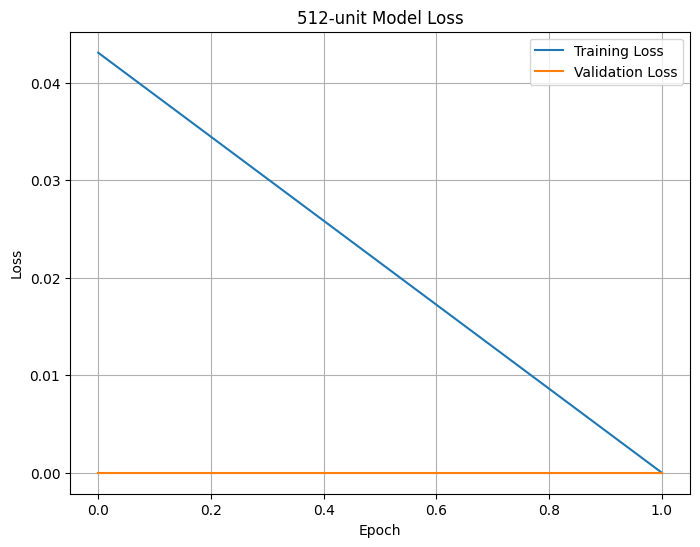

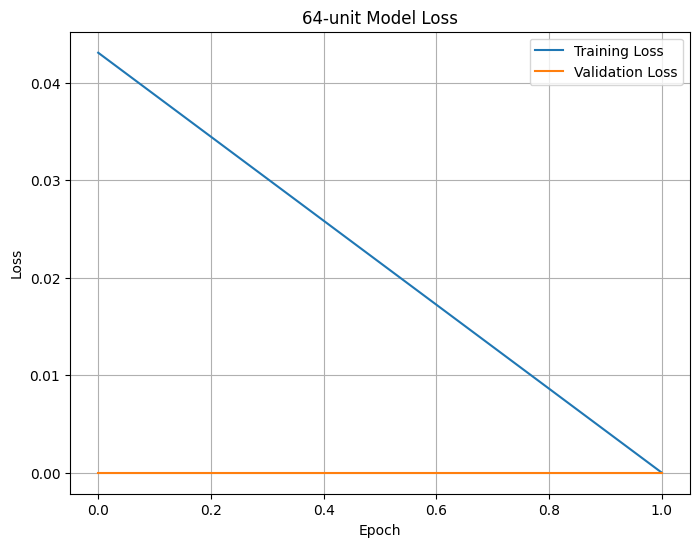

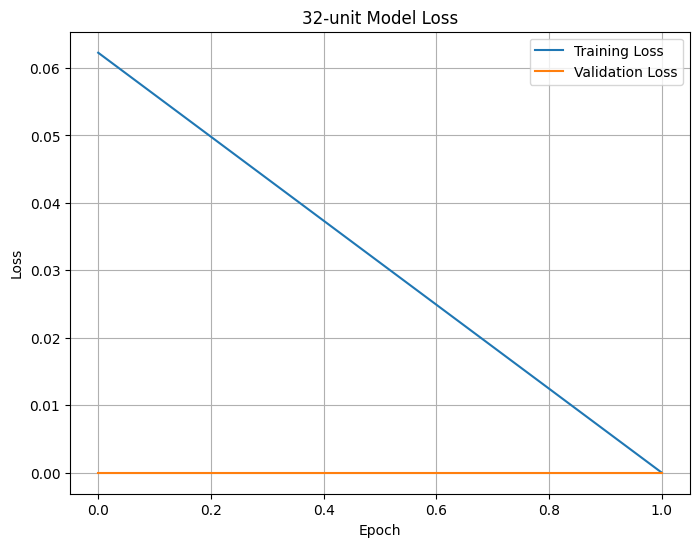

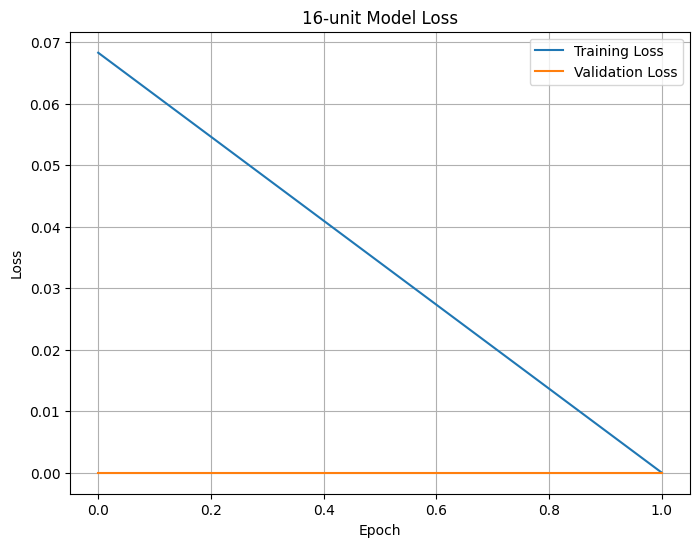

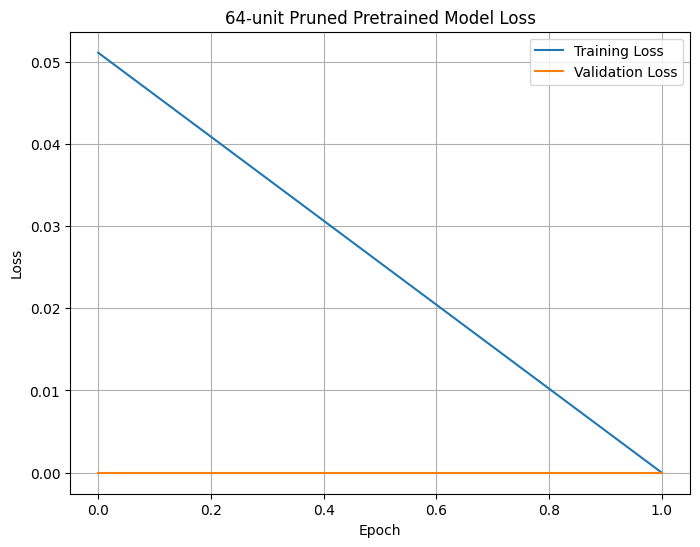

In [30]:
import matplotlib.pyplot as plt

def plot_loss(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history: # Check if validation loss was recorded
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# After training each model, call this function:
plot_loss(history_512_unit, '512-unit Model Loss')
plot_loss(history_64_unit, '64-unit Model Loss')
plot_loss(history_32_unit, '32-unit Model Loss')
plot_loss(history_16_unit, '16-unit Model Loss')
plot_loss(history_pruned_from_pretrained, '64-unit Pruned Pretrained Model Loss')
# ... and so on for other models

In [31]:
# # 1. Set up pruning params for instant pruning (no fine-tuning)


# pruning_params_oneshot = {
#     "initial_sparsity": 0.875,
#     "final_sparsity": 0.875,
#     "begin_step": 0,
#     "end_step": 1,
# }



# # 2. Create the pruned model (use_pruning=True)
# model_pruned_oneshot = E2ESystemConventionalTraining(
#     training=True,
#     use_pruning=True,
#     pruning_params=pruning_params_oneshot,
#     demapper_type='512'
# )

# pruning_callbacks_oneshot = [
#     tfmot.sparsity.keras.UpdatePruningStep()
# ]

# # 3. Build and load weights
# dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
# model_pruned_oneshot(dummy_input, training=False)
# model_pruned_oneshot.load_weights('conventional_weights_512.h5',by_name=True, skip_mismatch=True)

# # 4. Compile and run one batch through .fit() to trigger pruning
# model_pruned_oneshot.compile(optimizer=tf.keras.optimizers.Adam())
# model_pruned_oneshot.fit(
#     data_gen.take(2),  # Just one batch to trigger mask update
#     epochs=1,
#     callbacks=pruning_callbacks_oneshot,
#     verbose=0
# )

# # Print sparsity before stripping
# print("\nPruned demapper sparsity BEFORE stripping:")
# print_model_sparsity(model_pruned_oneshot._demapper)

# # 5. Strip pruning wrappers
# model_pruned_oneshot._demapper = tfmot.sparsity.keras.strip_pruning(model_pruned_oneshot._demapper)

# # Print sparsity after stripping
# print("\nPruned demapper sparsity BEFORE stripping:")
# print_model_sparsity(model_pruned_oneshot._demapper)

# # 6. Save the weights
# model_pruned_oneshot.save_weights('model_weights_pruned_oneshot.h5')


**Evaluation Pipeline**

In [32]:
# Conventional evaluation model
model_conventional_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='512'
)
dummy_input = (tf.zeros([1, n]), tf.zeros([1]))

model_conventional_eval(dummy_input, training=False)
model_conventional_eval.load_weights('conventional_weights_512.h5')

# 64-unit evaluation model
model_64unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='64'
)
model_64unit_eval(dummy_input, training=False)
model_64unit_eval.load_weights('model_weights_64unit.h5')

# 32-unit evaluation model
model_32unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='32'
)
model_32unit_eval(dummy_input, training=False)
model_32unit_eval.load_weights('model_weights_32unit.h5')


# 16-unit evaluation model
model_16unit_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    demapper_type='16'
)
model_16unit_eval(dummy_input, training=False)
model_16unit_eval.load_weights('model_weights_16unit.h5')

pruning_params = {
    "initial_sparsity": 0.0,
    "final_sparsity": 0.875,
    "begin_step": 0,
    "end_step": 1000,
}

# Pruned evaluation model
# model_pruned_eval = E2ESystemConventionalTraining(
#     training=False,
#     use_pruning=False,
#     pruning_params=pruning_params_normal,
#     demapper_type='512'
# )
# model_pruned_eval(dummy_input, training=False)
# model_pruned_eval.load_weights('model_weights_pruned.h5')


# Pruned Pretrained Evaluation

model_pruned_from_pretrained_eval = E2ESystemConventionalTraining(
    training=False,
    use_pruning=False,
    pruning_params=pruning_params,
    demapper_type='512'
)
model_pruned_from_pretrained_eval(dummy_input, training=False)
model_pruned_from_pretrained_eval.load_weights('model_weights_pruned_from_pretrained_512_to_64_equivalent.h5')

# pruning_params = {
#     "initial_sparsity": 0.875,
#     "final_sparsity": 0.875,
#     "begin_step": 0,
#     "end_step": 1,
# }

# #Pruned Oneshot eval

# model_pruned_oneshot_eval = E2ESystemConventionalTraining(
#     training=False,
#     use_pruning=True,
#     pruning_params=pruning_params,
#     demapper_type='512'
# )
# model_pruned_oneshot_eval(dummy_input, training=False)
# model_pruned_oneshot_eval.load_weights('model_weights_pruned_oneshot.h5')


*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************
*********Inside Gaussian Distributed PN************


**Post Training Quantization Pipeline**

In [33]:
# def representative_data_gen():
#     for _ in range(100):
#         dummy_input = np.random.randn(1, num_symbols_per_codeword, 4).astype(np.float32)
#         yield [dummy_input]

# # Extract trained demapper from conventional model
# demapper_model = create_functional_demapper_phase_noise_from_preprocessed(num_bits_per_symbol,bitwise=True)
# model_float = E2ESystemConventionalTraining(training=False)
# dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
# model_float(dummy_input, training=False)
# model_float.load_weights('conventional_weights_512.h5')
# demapper_model = model_float._demapper  # Should be a Keras model/layer

# import tensorflow as tf
# converter = tf.lite.TFLiteConverter.from_keras_model(demapper_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
# converter._experimental_disable_quant_scale_range_check = True
# tflite_quant_model = converter.convert()
# with open("quantized_demapper.tflite", "wb") as f:
#     f.write(tflite_quant_model)

# class QuantizedDemapperWrapper(tf.keras.layers.Layer):
#     def __init__(self, interpreter_path):
#         super().__init__()
#         self.interpreter = tf.lite.Interpreter(model_path=interpreter_path, num_threads=1)
#         self.interpreter.allocate_tensors()
#         self.input_details = self.interpreter.get_input_details()
#         self.output_details = self.interpreter.get_output_details()

#     def _wrapped_call_single(self, z_single):
#         input_scale = self.input_details[0]['quantization'][0]
#         input_zero_point = self.input_details[0]['quantization'][1]
#         z_quant = np.round(z_single / input_scale + input_zero_point)
#         z_quant = np.clip(z_quant, -128, 127).astype(np.int8)
#         if z_quant.ndim == 2:
#             z_quant = np.expand_dims(z_quant, axis=0)
#         self.interpreter.set_tensor(self.input_details[0]['index'], z_quant)
#         self.interpreter.invoke()
#         output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
#         output_scale, output_zero_point = self.output_details[0]['quantization']
#         output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
#         return output_float[0]

#     def call(self, z):
#         return tf.map_fn(
#             lambda x: tf.py_function(self._wrapped_call_single, [x], tf.float32),
#             z,
#             fn_output_signature=tf.TensorSpec(shape=(num_symbols_per_codeword, num_bits_per_symbol), dtype=tf.float32)
#         )

# # Plug quantized demapper into E2E model for evaluation
# model_quantized = E2ESystemConventionalTraining(training=False)
# dummy_input = (tf.zeros([1, 1]), tf.zeros([1]))
# model_quantized(dummy_input, training=False)
# model_quantized.load_weights('conventional_weights_512.h5')
# model_quantized._demapper = QuantizedDemapperWrapper("quantized_demapper.tflite")


In [34]:
# interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
# input_details = interpreter.get_input_details()
# print(input_details[0]['dtype'])  # Should be np.float32 or np.uint8


In [35]:
# import tensorflow as tf

# interpreter = tf.lite.Interpreter(model_path="quantized_demapper.tflite")
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("Input dtype:", input_details[0]['dtype'])    # e.g., np.float32 or np.uint8
# print("Output dtype:", output_details[0]['dtype'])  # e.g., np.float32 or np.uint8


## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [36]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x, no) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [37]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [38]:
# class SimberCompatibleWrapper(tf.keras.Model):
#     def __init__(self, base_model):
#         super().__init__()
#         self.base_model = base_model

#     def call(self, batch_size, ebno_db):
#         # If ebno_db is scalar, tile it to batch_size
#         if len(ebno_db.shape) == 0:
#             ebno_db = tf.fill([batch_size], ebno_db)
#         elif ebno_db.shape[0] != batch_size:
#             ebno_db = tf.broadcast_to(ebno_db, [batch_size])
#         x = tf.zeros([batch_size, 1], dtype=tf.float32)
#         return self.base_model((x, ebno_db), training=False)


In [39]:
class SimberCompatibleWrapper(tf.keras.Model):
    def __init__(self, base_model, n):
        super().__init__()
        self.base_model = base_model
        self.n = n

    def call(self, batch_size, ebno_db):
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        elif ebno_db.shape[0] != batch_size:
            ebno_db = tf.broadcast_to(ebno_db, [batch_size])
        c = tf.zeros([batch_size, self.n], dtype=tf.float32)
        return self.base_model((c, ebno_db), training=False)


In [40]:

# Dictionary storing the results
BER = {}

model_baseline = Baseline()
ber, _ = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['baseline'] = ber.numpy()


wrapped_model = SimberCompatibleWrapper(model_conventional_eval, n=n)
ber, _ = sim_ber(wrapped_model, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode="xla")
BER['autoencoder-conv'] = ber.numpy()

# Add 64-unit model to BER evaluation
wrapped_model_64 = SimberCompatibleWrapper(model_64unit_eval, n=n)
ber_64, _ = sim_ber(wrapped_model_64, ebno_dbs, batch_size=128,
                    num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-64unit'] = ber_64.numpy()

# Add 32-unit model to BER evaluation
wrapped_model_32 = SimberCompatibleWrapper(model_32unit_eval, n=n)
ber_32, _ = sim_ber(wrapped_model_32, ebno_dbs, batch_size=128,
                    num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-32unit'] = ber_32.numpy()

# wrapped_model_1 = SimberCompatibleWrapper(model_pruned_eval)
# ber, _ = sim_ber(wrapped_model_1, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode= None)
# BER['autoencoder-pruned'] = ber.numpy()

wrapped_model_2 = SimberCompatibleWrapper(model_16unit_eval, n=n)
ber, _ = sim_ber(wrapped_model_2, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-16unit'] = ber.numpy()

wrapped_model_3 = SimberCompatibleWrapper(model_pruned_from_pretrained_eval, n=n)
ber, _ = sim_ber(wrapped_model_3, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
BER['autoencoder-pruned-from-pretrained'] = ber.numpy()

# wrapped_model_4 = SimberCompatibleWrapper(model_pruned_oneshot_eval)
# ber, _ = sim_ber(wrapped_model_4, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=100, graph_mode=None)
# BER['autoencoder-pruned-oneshot'] = ber.numpy()


with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.3447e-01 | 1.0000e+00 |      165234 |     1228800 |         1024 |        1024 |        12.5 |reached target block errors
      4.5 | 1.2701e-01 | 1.0000e+00 |      156064 |     1228800 |         1024 |        1024 |         6.8 |reached target block errors
      5.0 | 1.1964e-01 | 1.0000e+00 |      147015 |     1228800 |         1024 |        1024 |         5.7 |reached target block errors
      5.5 | 1.1181e-01 | 1.0000e+00 |      137386 |     1228800 |         1024 |        1024 |         6.5 |reached target block errors
      6.0 | 1.0411e-01 | 1.0000e+00 |      127935 |     1228800 |         1024 |        1024 |         5.5 |reached target block errors
      6.5 | 9.5381e-02 | 1.0000e+00 |      117204 |     1228800 |

In [41]:
# import math
# sigmaphi = 0.08
# stddev_sigmaphi = math.sqrt(sigmaphi)

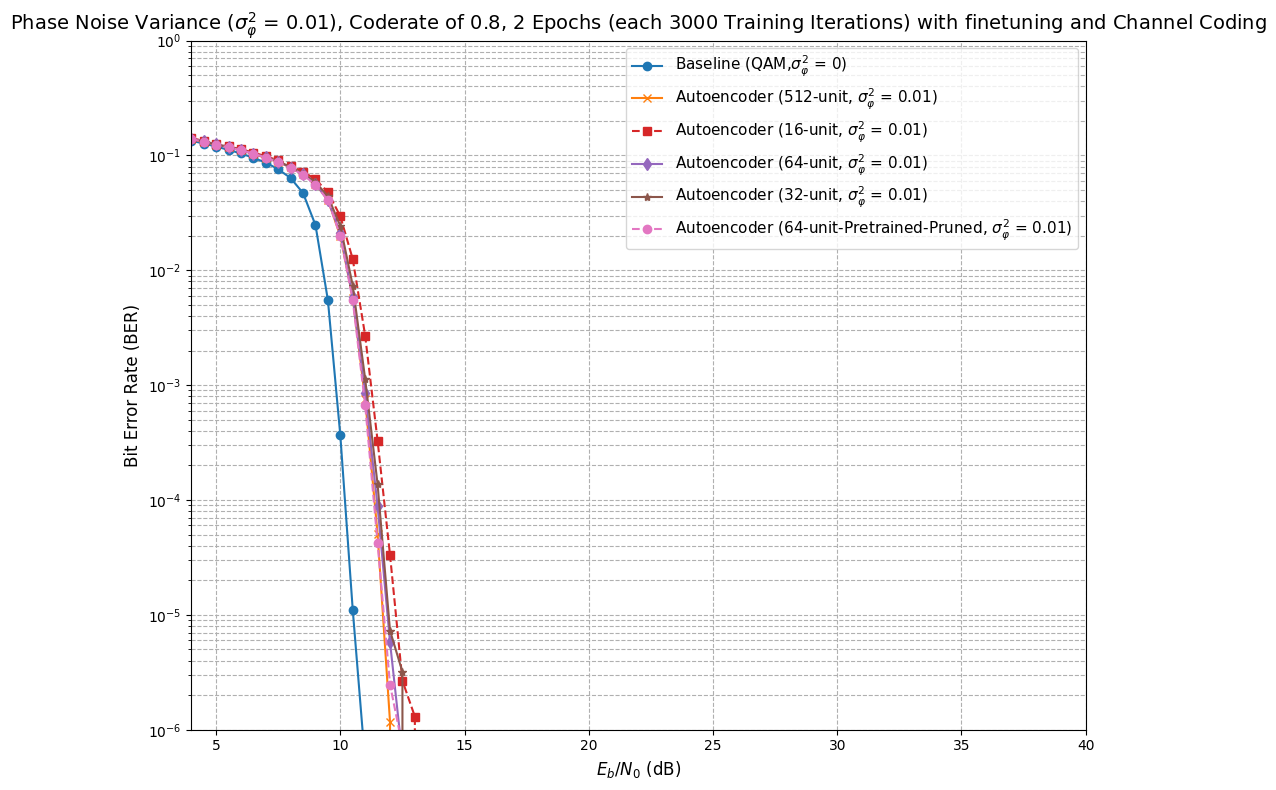

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Baseline (e.g., QAM)
plt.semilogy(ebno_dbs, BER['baseline'], 'o-', color='C0', label=fr"Baseline (QAM,$\sigma^2_\varphi$ = 0)")

# Autoencoder (conventional training)
plt.semilogy(ebno_dbs, BER['autoencoder-conv'], 'x-', color='C1', label=fr"Autoencoder (512-unit, $\sigma^2_\varphi$ = {sigmaphi})")

# Autoencoder (QAT-trained)
# plt.semilogy(ebno_dbs, BER['autoencoder-pruned'], 'x--', color='C2', label='Autoencoder (64 unit-Pruned,σ²φ = 0.07)')

# Autoencoder (Post-Training Quantized)
plt.semilogy(ebno_dbs, BER['autoencoder-16unit'], 's--', color='C3',label=fr"Autoencoder (16-unit, $\sigma^2_\varphi$ = {sigmaphi})")

# Update your plot to include the 64-unit results
plt.semilogy(ebno_dbs, BER['autoencoder-64unit'], 'd-', color='C4',label=fr"Autoencoder (64-unit, $\sigma^2_\varphi$ = {sigmaphi})")

# Update your plot to include the 32-unit results
# plt.semilogy(ebno_dbs, BER['autoencoder-32unit'], '*-', color='C5', label=fr'Autoencoder (32-unit,σ²φ = sigmaphi)')

plt.semilogy(ebno_dbs,BER['autoencoder-32unit'],'*-',color='C5',label=fr"Autoencoder (32-unit, $\sigma^2_\varphi$ = {sigmaphi})")


plt.semilogy(ebno_dbs, BER['autoencoder-pruned-from-pretrained'], 'o--', color='C6', label=fr"Autoencoder (64-unit-Pretrained-Pruned, $\sigma^2_\varphi$ = {sigmaphi})")

# plt.semilogy(ebno_dbs, BER['autoencoder-pruned-oneshot'], 'x--', color='C7', label='Autoencoder (64-unit-Oneshot-Pruned,σ²φ = 0.1)')

plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=12)
plt.ylabel("Bit Error Rate (BER)", fontsize=12)
plt.title(fr"Phase Noise Variance ($\sigma^2_\varphi$ = {sigmaphi}), Coderate of {coderate}, 2 Epochs (each {num_training_iterations_conventional} Training Iterations) with finetuning and Channel Coding",
          fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.8)
plt.ylim((1e-6, 1.0))
plt.xlim((ebno_db_min, ebno_db_max))
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [43]:
# print("Quantized model evaluation:")
# for layer in model_quantized.layers:
#     print(layer.__class__.__name__)


## Visualizing the Learned Constellations

In [44]:
def plot_constellation(model, title):
    points = tf.complex(model.points_r, model.points_i)
    model.constellation.points = points
    fig = model.constellation.show()
    fig.suptitle(title)
    return fig




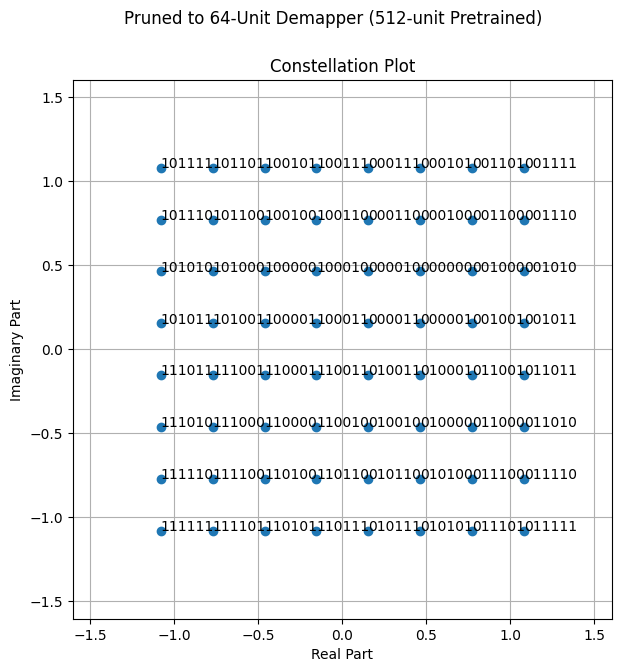

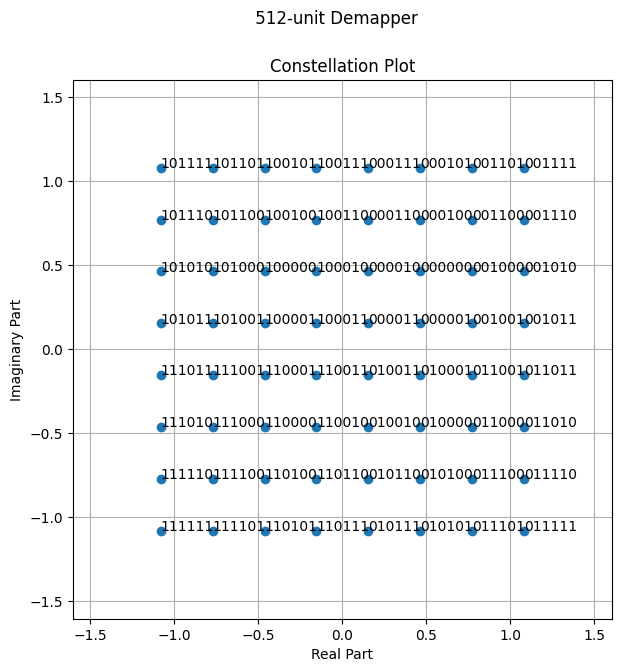

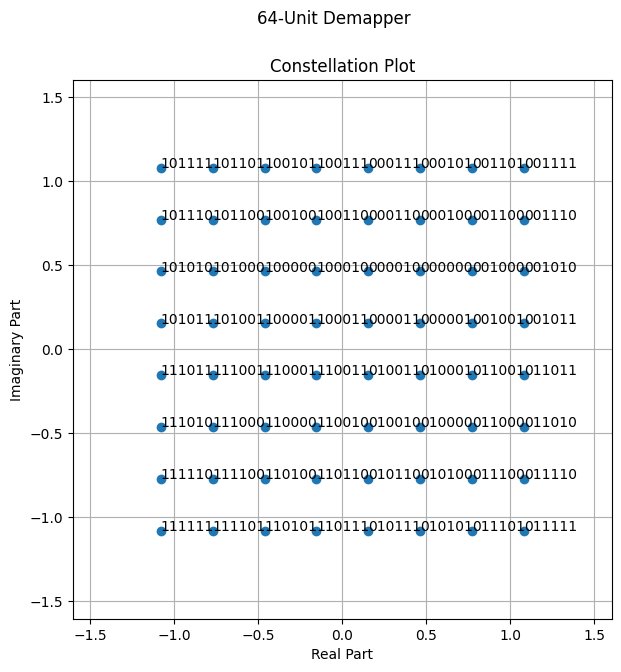

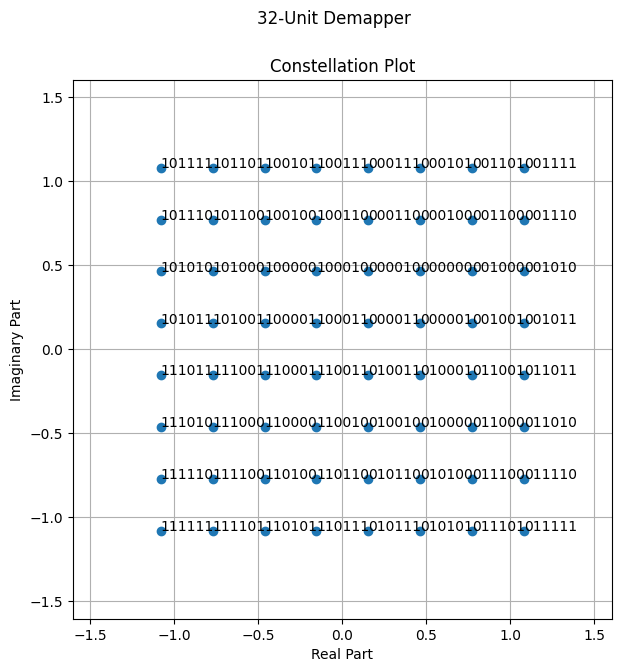

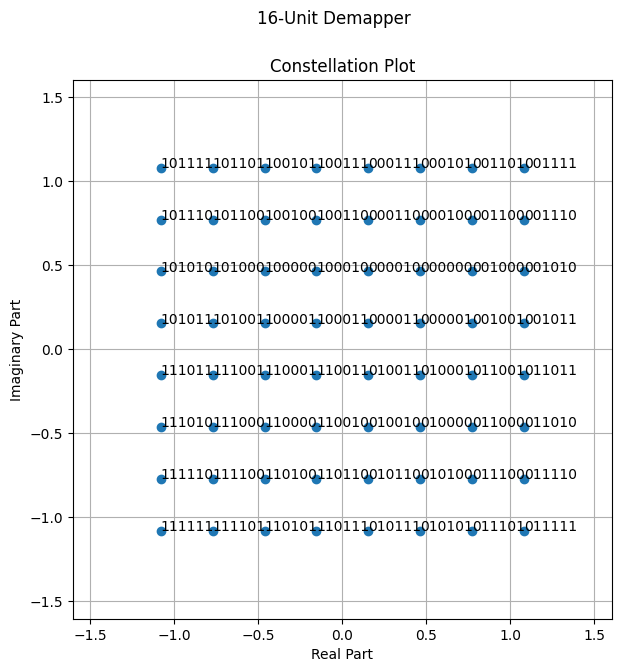

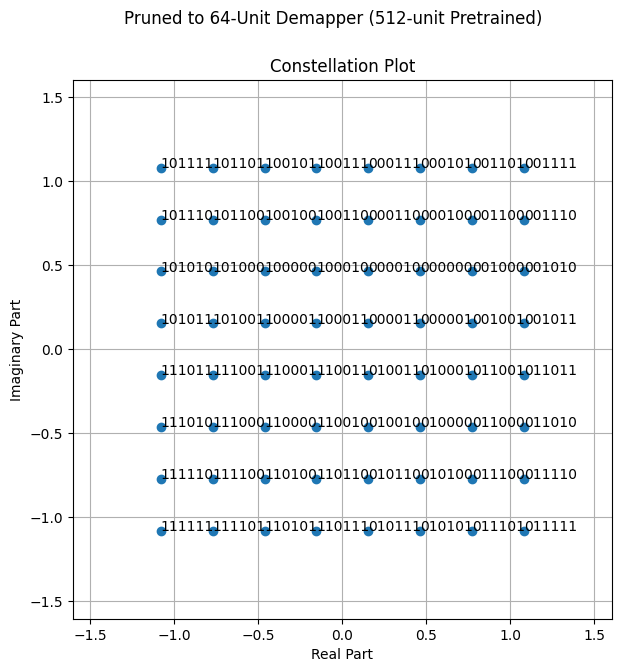

In [45]:
# Plot for 512-unit (conventional) model
plot_constellation(model_conventional_eval, " 512-unit Demapper")

# Plot for 64-unit model
plot_constellation(model_64unit_eval, "64-Unit Demapper")

# Plot for 32-unit model
plot_constellation(model_32unit_eval, "32-Unit Demapper")

# Plot for pruned model (512-unit)
# plot_constellation(model_pruned_eval, "Pruned to 64-Unit Demapper (512-unit Original)")

# Plot for quantized model
plot_constellation(model_16unit_eval, "16-Unit Demapper")

plot_constellation(model_pruned_from_pretrained_eval, "Pruned to 64-Unit Demapper (512-unit Pretrained)")

# plot_constellation(model_pruned_oneshot_eval, "Pruned to 64-Unit Demapper (512-unit Oneshot)")

**Phase noise + AWGN Impairment**

In [46]:
def plot_constellation_stages(model, ebno_db=8, num_samples=1000, title_prefix=""):
    """Plot constellation at different stages: AWGN only, Phase noise only, Joint"""

    # Generate test data
    test_input = (tf.zeros([num_samples, 1]), tf.fill([num_samples], ebno_db))

    # Get intermediate outputs
    intermediates = model.call_with_intermediates(test_input, training=False)

    # Extract constellation points
    x_awgn_only = intermediates['awgn_only'].numpy()
    x_phase_only = intermediates['phase_only'].numpy()
    x_joint = intermediates['joint'].numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: AWGN only
    axes[0].scatter(x_awgn_only.real, x_awgn_only.imag, alpha=0.6, s=10, color='blue')
    axes[0].set_title(f'{title_prefix}AWGN Only\n(Amplitude-dependent noise)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlabel('Real')
    axes[0].set_ylabel('Imaginary')
    axes[0].axis('equal')

    # Plot 2: Phase noise only
    axes[1].scatter(x_phase_only.real, x_phase_only.imag, alpha=0.6, s=10, color='orange')
    axes[1].set_title(f'{title_prefix}Phase Noise Only\n(Angular noise, σ²φ = 0.1)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlabel('Real')
    axes[1].set_ylabel('Imaginary')
    axes[1].axis('equal')

    # Plot 3: Joint impairment
    axes[2].scatter(x_joint.real, x_joint.imag, alpha=0.6, s=10, color='red')
    axes[2].set_title(f'{title_prefix}Joint Impairment\n(Phase Noise + AWGN, Eb/N0={ebno_db}dB)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlabel('Real')
    axes[2].set_ylabel('Imaginary')
    axes[2].axis('equal')

    plt.tight_layout()
    plt.show()

    return fig


In [47]:
def plot_multi_model_comparison(models_dict, ebno_db=8, num_samples=1000):
    """Compare multiple models side by side"""

    n_models = len(models_dict)
    fig, axes = plt.subplots(n_models, 3, figsize=(15, 5*n_models))

    if n_models == 1:
        axes = axes.reshape(1, -1)

    for i, (model_name, model) in enumerate(models_dict.items()):
        # Generate test data
        test_input = (tf.zeros([num_samples, 1]), tf.fill([num_samples], ebno_db))
        intermediates = model.call_with_intermediates(test_input, training=False)

        x_awgn_only = intermediates['awgn_only'].numpy()
        x_phase_only = intermediates['phase_only'].numpy()
        x_joint = intermediates['joint'].numpy()

        # Plot AWGN only
        axes[i, 0].scatter(x_awgn_only.real, x_awgn_only.imag, alpha=0.6, s=10, color='blue')
        axes[i, 0].set_title(f'{model_name}: AWGN Only')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].axis('equal')

        # Plot phase noise only
        axes[i, 1].scatter(x_phase_only.real, x_phase_only.imag, alpha=0.6, s=10, color='orange')
        axes[i, 1].set_title(f'{model_name}: Phase Noise Only')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].axis('equal')

        # Plot joint impairment
        axes[i, 2].scatter(x_joint.real, x_joint.imag, alpha=0.6, s=10, color='red')
        axes[i, 2].set_title(f'{model_name}: Joint Impairment')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].axis('equal')

    plt.tight_layout()
    plt.show()
    return fig


In [48]:
# Plot constellation stages for different models
print("Plotting constellation stages...")

# For conventional model (512-unit)
plot_constellation_stages(model_conventional_eval, ebno_db=8,
                         title_prefix="512-Unit: ")

# For 64-unit model
plot_constellation_stages(model_64unit_eval, ebno_db=8,
                         title_prefix="64-Unit: ")

# For 32-unit model
plot_constellation_stages(model_32unit_eval, ebno_db=8,
                         title_prefix="32-Unit: ")
# For pruned model
# plot_constellation_stages(model_pruned_eval, ebno_db=8,
#                          title_prefix="Pruned: ")


# Compare all models
models_to_compare = {
    '512-Unit': model_conventional_eval,
    '64-Unit': model_64unit_eval,
    '32-Unit': model_32unit_eval
    # 'Pruned': model_pruned_eval
}

plot_multi_model_comparison(models_to_compare, ebno_db=8)


Plotting constellation stages...


AttributeError: 'E2ESystemConventionalTraining' object has no attribute 'call_with_intermediates'

## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.